In [1]:
import numpy as np
from neuron import h
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

h.load_file('stdrun.hoc')
#h.nrn_load_dll(os.path.join("biophys_components","mechanisms","modfiles","nrnmech.dll"))
h.nrn_load_dll(os.path.join("biophys_components","mechanisms","modfiles","x86_64",".libs","libnrnmech.so"))
fileList = os.listdir("biophys_components/templates")
for item in fileList:
    if not item.endswith('hoc'):
        fileList.remove(item)
print(fileList)


#for each file, load it into the hoc interpreter so it can be accessed
for item in fileList:
    h.load_file(os.path.join("biophys_components/templates/",item))
#make a list of all the cells being called, i.e., h.axoaxoniccell()
callNames = ["h." + fileList[i].split('_')[1].split('.')[0] + "()" for i in range(len(fileList))]
callNames.sort()
print(callNames)
#have to do this first, or you won't
for i in range(len(callNames)):
    myCell = eval(callNames[i])
    for sec in h.allsec(myCell):
        print(sec)

['class_axoaxoniccell.hoc', 'class_olmcell.hoc', 'class_pvbasketcell.hoc', 'class_pyramidalcell.hoc']
['h.axoaxoniccell()', 'h.olmcell()', 'h.pvbasketcell()', 'h.pyramidalcell()']
axoaxoniccell[0].soma[0]
axoaxoniccell[0].dend[0]
axoaxoniccell[0].dend[1]
axoaxoniccell[0].dend[2]
axoaxoniccell[0].dend[3]
axoaxoniccell[0].dend[4]
axoaxoniccell[0].dend[5]
axoaxoniccell[0].dend[6]
axoaxoniccell[0].dend[7]
axoaxoniccell[0].dend[8]
axoaxoniccell[0].dend[9]
axoaxoniccell[0].dend[10]
axoaxoniccell[0].dend[11]
axoaxoniccell[0].dend[12]
axoaxoniccell[0].dend[13]
axoaxoniccell[0].dend[14]
axoaxoniccell[0].dend[15]
olmcell[0].soma[0]
olmcell[0].dend[0]
olmcell[0].dend[1]
olmcell[0].axon[0]
pvbasketcell[0].soma[0]
pvbasketcell[0].dend[0]
pvbasketcell[0].dend[1]
pvbasketcell[0].dend[2]
pvbasketcell[0].dend[3]
pvbasketcell[0].dend[4]
pvbasketcell[0].dend[5]
pvbasketcell[0].dend[6]
pvbasketcell[0].dend[7]
pvbasketcell[0].dend[8]
pvbasketcell[0].dend[9]
pvbasketcell[0].dend[10]
pvbasketcell[0].dend[11]

In [2]:
#Injection values are taken from table 4 for the 4 middle ones,aac and pyr are from appendix 1 table 2
#make sure it is the same order as the callNames

In [3]:
InjList = [np.arange(-200,500,50),#aac
 #np.arange(-100,80,20),#cck
 #np.arange(-100,190,20),#ngf
 np.arange(-100,250,30),#olm
 np.arange(-300,500,50),#pv
 np.arange(-400,550,50)]#pyr

In [4]:
allTrials = []
for i in range(len(callNames)):
    myCell = eval(callNames[i])#make the cell
    Ia = InjList[i] /1000# nA ->pA# the current sweep for this particular cell
    allVs = []
    for j in range(len(Ia)):#test it at each current injection and save        
        iclamp = h.IClamp(myCell.soma[0](0.5))
        iclamp.delay = 150
        iclamp.dur = 1000
        iclamp.amp = Ia[j]
        v = h.Vector().record(myCell.soma[0](0.5)._ref_v)
        h.dt=0.2
        h.finitialize(-65)
        h.continuerun(1500)
        V = np.array(v)
        allVs.append(V)
    allTrials.append([allVs])#list of lists; each sublist has the current sweeps for the given cell

In [5]:
res = np.concatenate(allTrials,axis=1)[0].T#how I plotted it the first time.
time = np.arange(0,res.shape[0]*h.dt/1000,h.dt/1000)#time in seconds

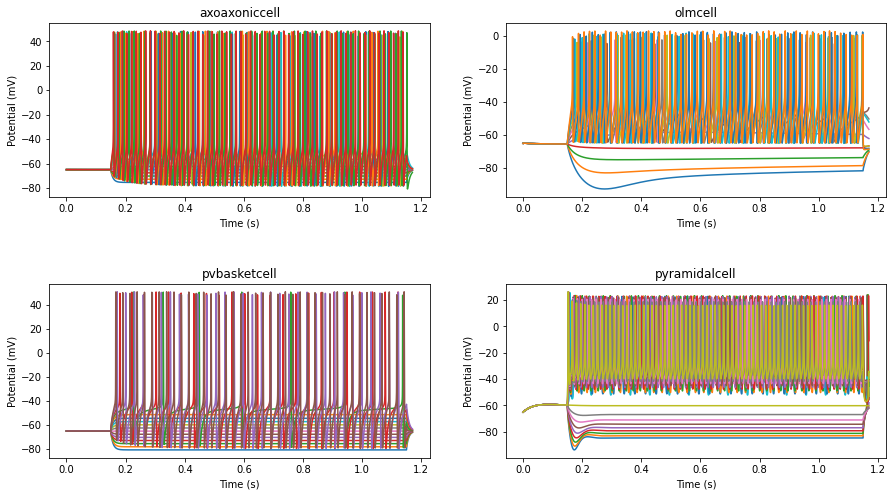

In [6]:
fig,axs = plt.subplots(2,2,figsize=(15,8))
plt.subplots_adjust(hspace=0.5)

start,k = 0,0
for i in range(2):
    for j in range(2):
        axs[i][j].plot(time[:5850],res[:5850,start:start+len(InjList[k])])
        axs[i][j].set_title(callNames[k].split('.')[1].split('()')[0])
        axs[i][j].set_xlabel('Time (s)')
        axs[i][j].set_ylabel('Potential (mV)')
        start += len(InjList[k])
        
        k+=1
#plt.savefig('current sweeps.png',dpi=500)

In [7]:
#convention: the first current clamp is the lowest

In [8]:
def restCalc(array,injL):#vrest
    if 0 not in injL:
        return  np.mean(array[int(iclamp.delay - 10):int(iclamp.delay-5),0])
    else:
        return  np.mean(array[:,np.where(injL ==0)[0]])
    

In [9]:
def rinCalc(array,injL):
    lhc = injL[np.where(injL<0)[0][-1]]#least hyperpolarized current, as per description following app1 table1
    Vinf  = np.mean(array[int(iclamp.delay + iclamp.dur - 100):int(iclamp.dur+iclamp.delay - 50),np.where(injL<0)[0][-1]])
    Vrest = restCalc(array,injL)
    Rin = (Vinf - Vrest) / (lhc/1000)#mv/pA ->Mohms
    return Rin
    

In [10]:
def curve(t,A,taum):
    return -65-A + A*np.e**((-t)/taum)

In [11]:
def findLDS(array):#find the least depolarized current which still gives spiking
    injIndex = None
    for i in range(0,array.shape[1]):
        peaks = find_peaks(array[int(iclamp.delay/h.dt):int(iclamp.delay/h.dt + iclamp.dur/h.dt),i],threshold = -20,prominence=10)[0]
        if(len(peaks) > 3):
            injIndex = i
            break
    return injIndex

In [12]:
def calcThresholds(array,injIndex):
    threshes = []
    for i in range(3):
        testArray = array[int(iclamp.delay/h.dt):int(iclamp.delay/h.dt + iclamp.dur/h.dt),injIndex].reshape(-1,1)
        peaks = find_peaks(testArray[:,0],threshold = -20,prominence=10)[0]
        avgISI = np.mean(np.diff(peaks))
        window = [int((peaks[i]) -avgISI/2),int((peaks[i] ) + avgISI/2 )]#isolate each peak
        testArray = testArray[window[0]:window[1],0].reshape(-1,1)
        
        if sum(np.diff(testArray[:,0] > 28)) ==0:#if the peak does not increase enough, find the first index at which the voltage is > 2 stdeviations from the mean
            #IDX = np.where(np.diff(testArray[:,0]) > np.mean(np.diff(testArray[:,0])) + 2 * np.std(np.diff(testArray[:,0])))[0][0] 
            return [0,1,2,3], peaks
        else:
            
            IDX = np.where(np.diff(testArray[:,0])> 28)[0][0]
        threshes.append(testArray[IDX,0])
    return threshes,peaks

In [13]:
def taumCalc(func,array,injL):#time array, followed by subarray
    window = [int(iclamp.delay/0.2),np.where(injL<0)[0][-1]]
    subArray = array[window[0]:int(iclamp.delay/0.2 + iclamp.dur/0.2 - 50),window[1]]
    t = np.arange(0,len(subArray))
    popt, _ = curve_fit(func,t,subArray)
    return popt[1]

In [14]:
def taumCalc2(func,array,injL):
    window = [int(iclamp.delay/0.2),np.where(injL<0)[0][-1]]
    subArray = array[window[0]:int(iclamp.delay/0.2 + iclamp.dur/0.2 - 50),window[1]]
    t = np.arange(0,len(subArray))
    initVal = np.abs(subArray[0])
    finalVal = np.abs(subArray[len(subArray)-1])
    dist = finalVal - initVal
    taum = t[np.where(np.abs(subArray) > finalVal - 1/np.e *dist)[0][0]]*0.2
    return taum

In [15]:
def sagAmpCalc(array,injL):
    #most hyperpolarized current injection level recording
    rec = array[:,0].reshape(-1,1)
    # steady state @ end of injection - max hyperpolarized potential
    ss = np.mean(rec[int(iclamp.delay/0.2 + iclamp.dur/0.2 - 50):int(iclamp.delay/0.2 + iclamp.dur/0.2),0] )
    mhc = np.min(rec)
    return ss - mhc

In [16]:
def tauSCalc(t,A,taus):
    return A * (1- np.e*(-t/taus))**4


In [17]:
def sagTauCalc(array,injL):
    minVal = array[np.where(array == np.min(array))[0][0]][0]
    ssVal = np.mean(array[int(iclamp.dur/h.dt + iclamp.delay/h.dt - 50)])
    return (minVal - ssVal )/ injL[0]

In [18]:
def rheobaseCalc(array,injL):
    for i in range(0,array.shape[1]):
        if(len(find_peaks(array[int(iclamp.delay/h.dt):int(iclamp.delay/h.dt + iclamp.dur/h.dt),i],threshold = -20,prominence=50)[0]) > 1):
            return injL[i]
            

In [19]:
def ISICalc(array,injL):
    meanISI = 0
    for i in range(0,array.shape[1]):
        peaks = find_peaks(array[int(iclamp.delay/h.dt):int(iclamp.delay/h.dt + iclamp.dur/h.dt),i],threshold = -20,prominence=50)[0]
        if(len(peaks) > 3):
            for i in range(len(peaks)-1):
                meanISI += peaks[i+1] - peaks[i]
            return meanISI/len(peaks) * h.dt
            

In [20]:
def thresholdCalc(array,injL):
    injIndex = findLDS(array)
    
    threshes,peaks = calcThresholds(array,injIndex)

    return np.mean(threshes)
    

In [21]:
def spikeAmpCalc(array,injL):
    injIndex = findLDS(array)
    threshdiffs = []
    for i in range(3):
        testArray = array[int(iclamp.delay/h.dt):int(iclamp.delay/h.dt + iclamp.dur/h.dt),injIndex].reshape(-1,1)
        peaks = find_peaks(testArray[:,0],threshold = -20,prominence=10)[0]
        avgISI = np.mean(np.diff(peaks))
        window = [int((peaks[i]) -avgISI/2),int((peaks[i] ) + avgISI/2 )]
        testArray = testArray[window[0]:window[1],0].reshape(-1,1)
        peaks = find_peaks(testArray[:,0],threshold = -20,prominence=10)[0]
        if sum(np.diff(testArray[:,0] > 28)) ==0:
            return [0,1,2,3]
            IDX = np.where(np.diff(testArray[:,0]) > np.mean(np.diff(testArray[:,0])) + 2 * np.std(np.diff(testArray[:,0])))[0][0] 
        else:
            IDX = np.where(np.diff(testArray[:,0])> 28)[0][0]
        threshdiffs.append(testArray[peaks[0],0] - testArray[IDX,0])
    return np.mean(threshdiffs)

Units of mV, also referred to simply as ‘AHP’ in the Appendix, the difference between the membrane potential  
at the most hyperpolarized potential following the action potential and the membrane potential at the threshold  
of the action potential, averaged for the first three spikes of the least depolarized current injection where the cell spiked regularly.

In [22]:
def ahpAmpCalc(array,injL):
    #find the least depolarized current injection with spiking
    injIndex = findLDS(array)
    threshes,peaks = calcThresholds(array,injIndex)
    avgISI = np.mean(np.diff(peaks))
    testArray = array[int(iclamp.delay/h.dt):int(iclamp.delay/h.dt + iclamp.dur/h.dt),injIndex].reshape(-1,1)
    diffs = []
    for i in range(3):
        window = [int((peaks[i]) -avgISI/2),int((peaks[i] ) + avgISI/2 )]
        minAHP = np.min(testArray[window[0]:window[1],:])
        diffs.append(threshes[i] - minAHP)
    
    return np.mean(diffs)


In [23]:
def summaryStats(array,injL):
    Vrest = restCalc(array,injL)
    Rin = rinCalc(array,injL)
    Taum = taumCalc2(curve,array,injL)
    SagAmp = sagAmpCalc(array,injL)
    SagTau = sagTauCalc(array,injL)
    rheobase = rheobaseCalc(array,injL)
    ISI = ISICalc(array,injL)
    Threshold = thresholdCalc(array,injL)
    SpikeAmp = spikeAmpCalc(array,injL)
    #AHPAmp = ahpAmpCalc(array,injL)
    statsList = [Vrest,Rin,SagAmp,SagTau,Taum,rheobase,ISI,Threshold,SpikeAmp]
    return statsList

In [24]:
passiveProps = []
for i in range(len(InjList)):
    subInj = InjList[i]
    subArray = np.array(allTrials[i][0]).T
    passiveProps.append(summaryStats(subArray,subInj))

In [25]:
rowNames = [callNames[i].split('.')[1].split('()')[0] for i in range(len(callNames))]

pd.DataFrame(passiveProps,index = rowNames,columns = ["Vrest","Rin","Sag Amp","sagTau","Taum","rheobase","ISI","Thresh","Spike Amp"]).round(2)

,Vrest,Rin,Sag Amp,sagTau,Taum,rheobase,ISI,Thresh,Spike Amp
axoaxoniccell,-65.01,52.28,0.00,0.02,7.2,200,54.84,-26.43,73.0765
olmcell,-65.16,234.68,10.95,0.32,28.0,50,84.80,1.50,"[0, 1, 2, 3]"
pvbasketcell,-65.02,52.11,0.00,0.06,7.2,300,130.17,-21.48,71.9449
pyramidalcell,-60.16,146.65,9.04,0.11,12.8,50,61.56,1.50,"[0, 1, 2, 3]"


In [ ]:
#rowNames = [callNames[i].split('.')[1].split('()')[0] for i in range(len(callNames))]

pd.DataFrame(passiveProps,index = rowNames,columns = ["Vrest","Rin","Sag Amp","sagTau","Taum","rheobase","ISI","Thresh","Spike Amp","AHP Amp"]).round(2)

In [ ]:
#injCalc = use time it takes for voltage to go to 1/e away from it's final value

# FI Curve

In [ ]:
rowNames = []
for i in range(len(callNames)):
    rowNames.append(callNames[i].split('.')[1].split('()')[0])
def frequencyCalc(array,InjList):
    freq = []
    for i in range(array.shape[1]):
        peaks = find_peaks(array[int(iclamp.delay/h.dt):int(iclamp.delay/h.dt + iclamp.dur/h.dt),i],threshold = -20,prominence=30)[0]
        freq.append((len(peaks) / ( iclamp.dur ))*1000)# ms^-1 -> s^-1
    return freq

In [ ]:
freqs = []
for i in range(len(InjList)):
    subInj = InjList[i]
    subArray = np.array(allTrials[i][0]).T
    freqs.append(frequencyCalc(subArray,subInj))


In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,5))
plt.subplots_adjust(hspace=0.5)
k=0
for i in range(2):
    for j in range(2):
        axs[i][j].plot(InjList[k],freqs[k])
        axs[i][j].set_title(rowNames[k])
        axs[i][j].set_xlabel('Current (pA)')
        axs[i][j].set_ylabel('Firing Rate (Hz)')
        k+=1
#plt.savefig('FI Curves.png',dpi=300,bbox_inches="tight")

# single cell tests

In [ ]:
callNames

In [ ]:
OLM = h.olmcell()
iclamp = h.IClamp(OLM.soma[0](0.1))
iclamp.delay = 100
iclamp.dur = 2
iclamp.amp = -0.1
v = h.Vector().record(AAC.soma[0](0.5)._ref_v)
h.dt=0.1
h.finitialize(-65)
h.continuerun(1500)
V = np.array(v)

In [ ]:
plt.plot(V)

In [ ]:
AAC = h.axoaxoniccell()

iclamp = h.IClamp(AAC.soma[0](0.5))
iclamp.delay = 100
iclamp.dur = 10
iclamp.amp = 10

vclamp = h.SEClamp(AAC.soma[0](0.5))
vclamp.dur1 = 100
vclamp.dur2 = 160
vclamp.dur3 = 170
#vclamp.amp1 = 0
#vclamp.amp2 = -70
vclamp.amp3 = -90
vclamp.rs1

v = h.Vector().record(AAC.soma[0](0.5)._ref_v)
h.dt=0.1
h.finitialize(-65)
h.continuerun(1500)
V = np.array(v)


In [ ]:
time = np.arange(0,1500.1,0.1)

In [ ]:
plt.plot(time[:3000],V[:3000])

In [ ]:
OLM = h.olmcell()
iclamp = h.IClamp(OLM.dend[1](0.5))
iclamp.delay = 100
iclamp.dur = 0.1
iclamp.amp = 0

iclamp2 = h.IClamp(OLM.dend[1](0.5))
iclamp2.delay = 100
iclamp2.dur = 1
iclamp2.amp = 0

iclamp3 = h.IClamp(OLM.dend[0](0.5))
iclamp3.delay = 102
iclamp3.dur = 50
iclamp3.amp = -0.1

v = h.Vector().record(OLM.soma[0](0.5)._ref_v)
i1 = h.Vector().record(iclamp._ref_i)
i2 = h.Vector().record(iclamp2._ref_i)
i3 = h.Vector().record(iclamp3._ref_i)


h.dt=0.1
h.finitialize(-65)
h.continuerun(1500)
Vn = np.array(v)
I1 = np.array(i1)
I2 =  np.array(i2)
I3 = np.array(i3)

In [ ]:
time = np.arange(0,1500,0.1)
start,end = 0,3000
plt.plot(time[start:end],Vn[start:end],label = 'vsoma')
plt.plot(time[start:end],I1[start:end]*10,label = 'I1')
plt.plot(time[start:end],I2[start:end]*10,label ='I2')
plt.plot(time[start:end],I3[start:end]*10,label ='I3')
plt.ylim([-90,0])
plt.legend()

In [ ]:
plt.plot(time[start:end],I1[start:end]*10,label = 'I1')

In [ ]:
OLM = h.axoaxoniccell()
Pyr = h
iclamp = h.IClamp(OLM.soma[0](0.5))
iclamp.delay = 100
iclamp.dur = 3
iclamp.amp = 2




h.dt=0.1
h.finitialize(-60)
h.continuerun(1500)
Vn = np.array(v)
I1 = np.array(i1)
I2 =  np.array(i2)
I3 = np.array(i3)

# channel dynamics

In [ ]:
myCell = h.pyramidalcell()

In [ ]:
myCell.soma[0].psection()

In [ ]:
testV = np.arange(-200,100)

In [ ]:
def HCNp(v):
    zetal = 4
    vhalfl = -90
    alpl = np.e**(0.0378 * zetal*(v - vhalfl))
    linf = 1/(1+ alpl)
    return linf

In [ ]:
plt.plot(testV,HCNp(testV))

In [ ]:
#table 3 is what we want to match, using the inputs from table 4

In [ ]:
# need to check vrest, tau, soma and dendrite dimensions, capacitance, Rin, reproduce current sweeps of fig 2 then automate output for each cell profile to compare with paper's experimental (and model?)
#results also number of compartments and segments
#table 4 shows the current sweeps used to test each cell

In [ ]:
#appendix1 figure 5 gives sweep for pyramidal cell
# app1 fig 7 is sweep for axoaxonic
#, 9 for bistratified, 11 for cck, 13 for ivy, 15 is ngf

In [ ]:
#appendix1 table 2 shows the current sweeps they got their experimental data from